In [5]:
from useful_functions import load_dataset, preprocessing, create_functional_model, create_structural_model, create_joint_model
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os
import pickle


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

SEED = 7

df_s_td, df_s_asd = load_dataset(dataset_name='Harmonized_structural_features.csv')
df_f_td, df_f_asd = load_dataset(dataset_name='Harmonized_functional_features.csv')

X_s = preprocessing(df_s_td)
X_f = preprocessing(df_f_td)

#check if targets are equal
y_s = df_s_td['AGE_AT_SCAN']
y_f = df_f_td['AGE_AT_SCAN']
print(y_s.equals(y_f))
y = np.array(y_s)

X_f_train, X_f_test, X_s_train, X_s_test, y_train, y_test = train_test_split(
        X_f,X_s, y, test_size=0.3, random_state=SEED)



True


In [3]:
def load_model(functional=False,structural=False):
    '''
    Re-train the best model obtained throug model selection using all available data.
    '''

    if structural:
        filename = 'structural_model_hyperparams.pkl'
        create_model = create_structural_model

    if functional:
        filename = 'functional_model_hyperparams.pkl'
        create_model = create_functional_model

    # Read dictionary pkl file
    with open(os.path.join('best_hyperparams',filename), 'rb') as fp:
        best_hyperparams = pickle.load(fp)


    model = create_model(dropout=best_hyperparams['model__dropout'],
                         hidden_neurons=best_hyperparams['model__hidden_neurons'],
                         hidden_layers=best_hyperparams['model__hidden_layers'])
    model.summary()

    return model

In [6]:
ms = load_model(structural=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 221)               0         
                                                                 
 batch_normalization (Batch  (None, 221)               884       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 30)                6660      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 30)                120       


2023-11-13 11:15:26.090435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 11:15:26.679933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 7695 (30.06 KB)
Trainable params: 7193 (28.10 KB)
Non-trainable params: 502 (1.96 KB)
_________________________________________________________________


In [7]:
mf = load_model(functional=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 5253)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 5253)              21012     
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               525400    
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 100)              

In [8]:

from keras.models import Sequential, Model
from keras.layers import Input, Dense,Dropout,BatchNormalization, concatenate
from keras.regularizers import l1
from keras.optimizers.legacy import Adam



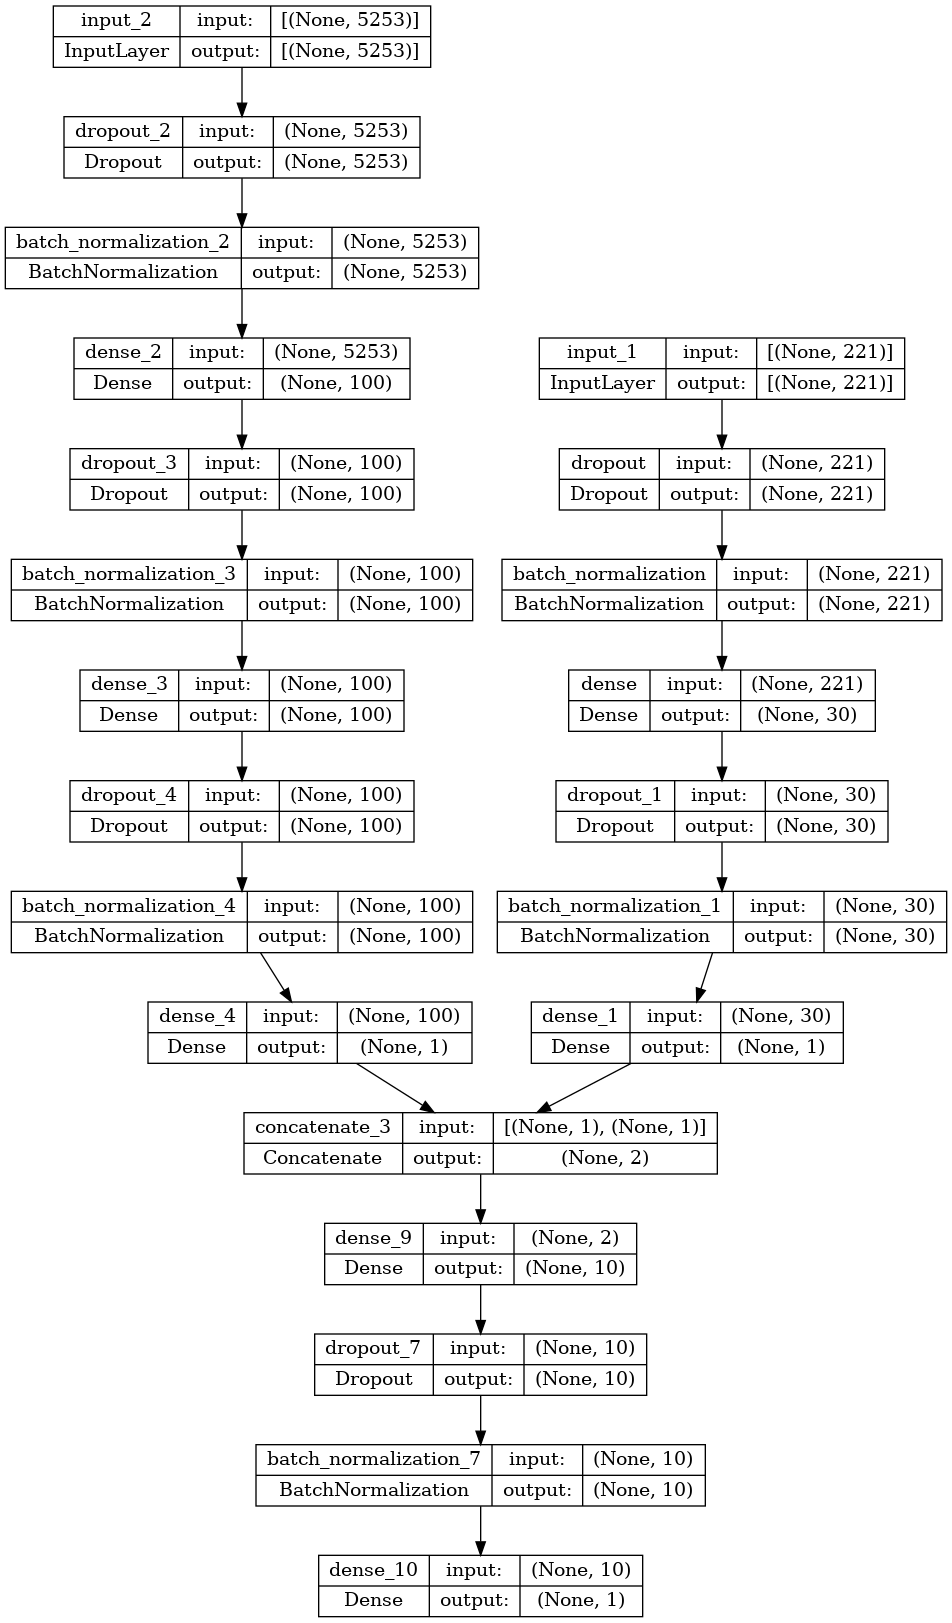

In [12]:
model_concat = concatenate([mf.output, ms.output], axis=-1)


model_concat = Dense(10, activation='relu',kernel_regularizer=l1(0.01))(model_concat)
model_concat = Dropout(0.2)(model_concat)
model_concat = BatchNormalization()(model_concat)

model_concat = Dense(1, activation='linear',kernel_regularizer=l1(0.01))(model_concat)

model = Model(inputs=[mf.input, ms.input], outputs=model_concat)


#compile the model
optim = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optim)


#plot the model architecture
plot_model(model, "architecture_joint_model.png", show_shapes=True)